<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [2]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive

In [3]:

# !tar -xvf '{ROOT_FOLDER}handout.tar' -C '{ROOT_FOLDER}'
from collections import Counter
import string
import os

import numpy as np
import json
from google.colab import drive

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim

# many outputs one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
# %matplotlib inline

drive.mount('/content/gdrive', force_remount=True)
ROOT_FOLDER = 'gdrive/My Drive/Colab_Notebooks/dls_2/21_DIPLOM_Image_captioning/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/gdrive
cuda


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [4]:
# загружаем датасет
img_codes = np.load(ROOT_FOLDER + "data/image_codes.npy")
captions_src = json.load(open(ROOT_FOLDER+'data/captions_tokenized.json'))

# размерности
print(len(captions_src), len(captions_src[0]))
print(img_codes.shape)

# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions_src[0]))

118287 5
(118287, 2048)
Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


people shopping in an open market for vegetables .
a shoe rack with some shoes and a dog sleeping on them

after drop punct
people shopping in an open market for vegetables 
a shoe rack with some shoes and a dog sleeping on them

after sos/eos
sos people shopping in an open market for vegetables  eos
sos a shoe rack with some shoes and a dog sleeping on them eos

after filter by counter
sos people shopping in an open market for vegetables  eos
sos a shoe rack with some shoes and a dog sleeping on them eos
59
13.243301461699089
14

after padding
sos people shopping in an open market for vegetables  pad_token pad_token pad_token eos
sos a shoe rack with some shoes and a dog sleeping on them eos


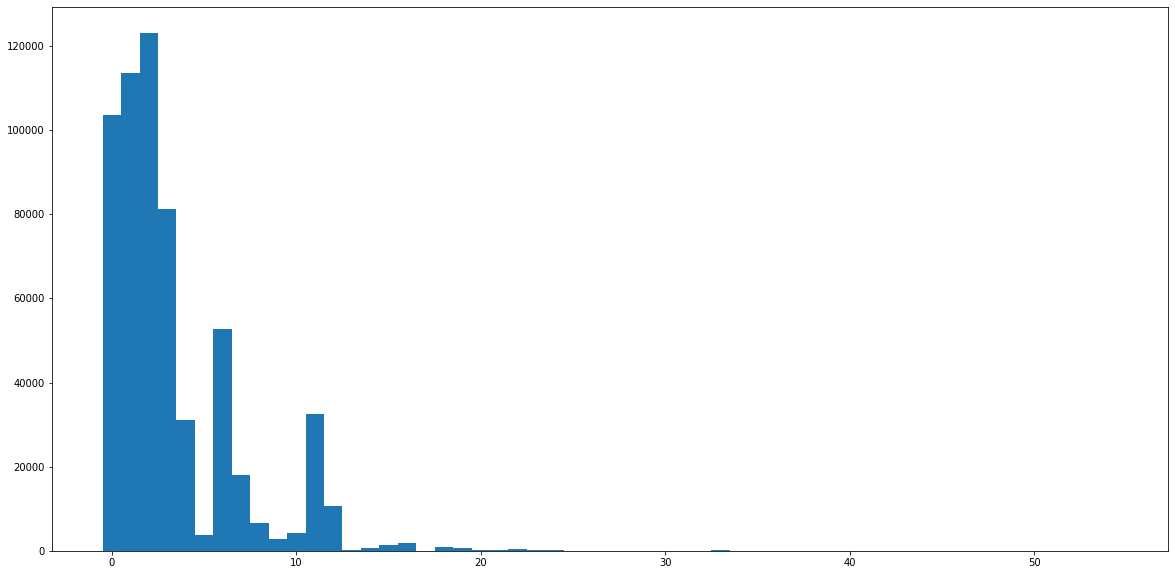

In [5]:
# preparations
def test_transforms(captions):
  print(captions[0][0])
  print(captions[24][4])


  # drop punctuation
  table = str.maketrans('', '', string.punctuation)
  for i in range(len(captions)):
    for j in range(len(captions[i])):
      captions[i][j] = captions[i][j].translate(table)
  print('\nafter drop punct')
  print(captions[0][0])
  print(captions[24][4])

  # sos, eos
  for i in range(len(captions)):
    for j in range(len(captions[i])):
      captions[i][j] = 'sos ' + captions[i][j] + ' eos'
  print('\nafter sos/eos')
  print(captions[0][0])
  print(captions[24][4])

  # TODO: лематизация, мб впилить? Будет более четкий словарь


  # word counter
  c = Counter()
  c['pad_token'] += 100500
  for sents in captions:
    for sent in sents:
      for w in sent.split(' '):
        c[w] += 1
  # словарик с токенами и их кодом
  words_dict = {word:i for i, word in enumerate(c)}

  # drop всех, что не вошли в словарь слов 
  for i in range(len(captions)):
    for j in range(len(captions[i])):
      # получаем список слов, удаляем из списка те, что недостойны
      words = [w for w in captions[i][j].split(' ') if c[w]>=5]
      # собираем список в строку, закидываем ее вместо исходной captions
      captions[i][j] = ' '.join(words)

  print('\nafter filter by counter')
  print(captions[0][0])
  print(captions[24][4])

  # ищем макс длину, а также массив и словарь длин
  len_arr = []
  c_len = Counter()
  max_l = 0
  for sents in captions:
    for sent in sents:
      len_arr.append(len(sent.split(' ')))
      c_len[len(sent.split(' '))] += 1
      max_l = max_l if max_l > len(sent.split(' ')) else len(sent.split(' '))
  print(max_l)
  len_arr = np.array(len_arr)
  print(len_arr.mean())
  border = int(np.ceil(np.percentile(len_arr, 70)))
  print(border)


  # стоим гистограммку
  plt.rcParams["figure.figsize"] = (20,10)
  labels, values = zip(*c_len.items())

  indexes = np.arange(len(labels))
  width = 1

  bar = plt.bar(indexes, values, width)


  # докидываем падинги, берем 70й перцентиль как порог
  for i in range(len(captions)):
    for j in range(len(captions[i])):
      delt_len = border - len(captions[i][j].split(' '))
      # перед eos засунем pad столько раз, на сколько дельта длины
      if delt_len > 0:
        if captions[i][j][-1] != ' ':
          captions[i][j] += ' '
        captions[i][j] = captions[i][j][:-4] + 'pad_token ' * delt_len + 'eos'

  print('\nafter padding')
  print(captions[0][0])
  print(captions[24][4])
  return words_dict
# copy() не достаточно, не смотря на это, все равно мешаются исходные данные - нужно пройти циклом и для каждого внутреннего листа создать новый объект
captions = []
for c in captions_src:
    new_sent = list(c)
    captions.append(new_sent)

words_dicts = test_transforms(captions)

Класс и гистограмка и все эти обработки написаны в первую очередь для демонстрации понимания работы с эбедами и классами DataSet, DataLoader

## DataSet and DataLoader

In [6]:
ar = torch.tensor([14, 15252])

words = []
for word_number in ar:
  # get this word from dict
  for w in words_dicts:
    if words_dicts[w] == word_number:
      words.append(w)
words

['and', 'lily']

In [7]:
class TextAndImageDataset(Dataset):
  def __init__(self, captions: list, img_codes: np.array, word_dict):
    self.captions = captions
    self.img_codes = img_codes
    self.words_dict = word_dict

  def __getitem__(self, item_index):
    text = self._get_text(item_index)
    embeds = self._get_embedings(text)
    img = self._get_image(item_index)
    return {"text" : text, "embeds": embeds, "img": img}

  def __len__(self):
    return len(self.captions)


  def _get_text(self, item_index):
    return self.captions[item_index][np.random.randint(5)]

  def _get_image(self, item_index):
    return self.img_codes[item_index]

  def _get_embedings(self, text):
    words = text.split(' ')
    embeds = np.array([self.words_dict[w] for w in words])[:14]
    return embeds

# TODO: mb add test?
train_size = round(len(captions) * 0.8)
train_txt_img_dataset = TextAndImageDataset(captions[:train_size], img_codes[:train_size], words_dicts)
valid_txt_img_dataset = TextAndImageDataset(captions[train_size:], img_codes[train_size:], words_dicts)
train_txt_img_dataset[0]

{'embeds': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  0,  0, 11]),
 'img': array([0.3659946 , 0.2016555 , 0.9245725 , ..., 0.00344942, 0.99817497,
        1.1091837 ], dtype=float32),
 'text': 'sos people shopping in an open market for vegetables  pad_token pad_token pad_token eos'}

In [8]:
# я искренне ненавижу торчовый лоадер, который подыхает в абсолютно рандомных местах, например когда у меня дедлайн
# закодим ему простейшую collate_fn, а парсить как надо будем сами, оставив ему на откуп функцию итератора
train_loader = DataLoader(train_txt_img_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: x)
valid_loader = DataLoader(valid_txt_img_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: x)
print(next(iter(train_loader))[:2])

[{'text': 'sos a group of men are playing baseball outside  pad_token pad_token pad_token eos', 'embeds': array([  1,  23, 105,  13,  88,  16, 168, 281, 248,  10,   0,   0,   0,
        11]), 'img': array([0.42093042, 0.26095992, 0.72297513, ..., 0.29202813, 1.0366824 ,
       0.05635927], dtype=float32)}, {'text': 'sos a dark street lit with bright multicolored lights pad_token pad_token pad_token pad_token eos', 'embeds': array([   1,   23,  491,   96,  896,   57,  753, 1579, 1400,    0,    0,
          0,    0,   11]), 'img': array([0.6468027 , 0.13087766, 0.11500521, ..., 0.22617574, 0.7783188 ,
       0.01990073], dtype=float32)}]


In [9]:
batch = next(iter(train_loader))
img_embeds = torch.tensor([x['img'] for x in batch])
captions_embed = torch.tensor([x['embeds'] for x in batch])
txt = [x['text'] for x in batch]
txt
captions_embed

['sos a man riding a wave on to of a surfboard  pad_token eos',
 'sos a skier in a red and blue jacket traveling upwards on a hill  eos',
 'sos a women who is eating a piece of food  pad_token pad_token eos',
 'sos several sheep make their way down a rural street  pad_token pad_token eos',
 'sos a woman and young child sitting in front of a computer monitor  eos',
 'sos food prepared on a clear plate while sitting on a table  eos',
 'sos an adult man hugs a stuffed teddy bear  pad_token pad_token pad_token eos',
 'sos a picture of a london underground sign and big ben pad_token pad_token eos',
 'sos a red vase with an assortment of flowers in it pad_token pad_token eos',
 'sos a very large person riding a bike down the street  pad_token eos',
 'sos us airways plane moving on a taxi way near its gate at an airport  eos',
 'sos a black cat is sleeping on a table full of papers  eos',
 'sos a small girl sitting at a table with food and drinks pad_token eos',
 'sos pitcher preparing to thr

tensor([[    1,    23,    56,    77,    23,   745,    34,   116,    13,    23,
           741,    10,     0,    11],
        [    1,    23,    39,     4,    23,   194,    14,    53,   195,  1312,
          6162,    34,    23,    32],
        [    1,    23,   267,    55,    40,   180,    23,   529,    13,   181,
            10,     0,     0,    11],
        [    1,   111,   591,   391,   383,  1148,    30,    23,  1636,    96,
            10,     0,     0,    11],
        [    1,    23,   262,    14,   114,   289,   138,     4,   157,    13,
            23,   153,  1624,    10],
        [    1,   181,  1477,    34,    23,  1033,   291,   172,   138,    34,
            23,    70,    10,    11],
        [    1,     5,   932,    56,  6671,    23,   196,   371,    92,    10,
             0,     0,     0,    11],
        [    1,    23,   101,    13,    23,  1573,  4553,   359,    14,   162,
          1570,     0,     0,    11],
        [    1,    23,   194,   241,    57,     5,  1330,    13,

Вроде похоже на правду 

### 2. Напишем свою сетку из RNN для вывода описаний


### Model

Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [10]:
class CaptionNet(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(CaptionNet, self).__init__()
        
        # init
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
    
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки не нужны, заполним их empty
      

        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
    
        # 2. слой эмбедднга вокруг текста
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)


        # 3. 1 или несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        self.lstm_cell = nn.LSTMCell(input_size=embed_size, hidden_size=hidden_size)
    
        # 4. Посчитаем выходы
        # self.softmax = nn.Softmax(dim=vocab_size)
    
    def forward(self, features, captions, mode = 'train', words_capt = 14, teacher_forcing_rate = 1):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """

        batch_size = features.size(0)
        
        # 1. инициализируем LSTM state
        hidden_state = torch.zeros((batch_size, self.hidden_size)).cuda()
        cell_state = torch.zeros((batch_size, self.hidden_size)).cuda()
    
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).cuda() if mode == 'train' else \
          torch.empty((batch_size, words_capt, self.vocab_size)).cuda()

        captions_embed = self.embed(captions) # embed the captions
        
        # трейн - фича форсинг
        if mode == 'train':
          for t in range(captions.size(1)):

              if t == 0:
                  hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
              else:
                  # решаем, сработает ли teacher forcing на этом шаге
                  if np.random.uniform() > teacher_forcing_rate:
                    prev_word = torch.argmax(outputs[:, t-1, :], dim=1)
                    embed_prev_word = self.embed(prev_word)
                    hidden_state, cell_state = self.lstm_cell(embed_prev_word, (hidden_state, cell_state))
                  else:
                    hidden_state, cell_state = self.lstm_cell(captions_embed[:, t, :], (hidden_state, cell_state))
              out = self.fc_out(hidden_state)
              outputs[:, t, :] = out


        # а тут будем всегда генерить слово по прошлому + картинке
        else:
          for t in range(words_capt):

            # первое слово по картинке
            if t == 0:
                hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
                
            # второе и дальше - из аутпута
            else:
                prev_word = torch.argmax(outputs[:, t-1, :])
                embed_prev_word = self.embed(prev_word).unsqueeze(0)
                hidden_state, cell_state = self.lstm_cell(embed_prev_word, (hidden_state, cell_state))
            
            # output of the attention mechanism
            out = self.fc_out(hidden_state)
            
            # build the output tensor
            outputs[:, t, :] = out

    
        return outputs

    def sample(self, inputs):
        " отдельная функция для семплинга "
        output = []
        # print(f'inputs.shape: {inputs.shape}')
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = (torch.zeros((batch_size, self.hidden_size)).cuda(), torch.zeros((batch_size, self.hidden_size)).cuda())
        # hidden = self.init_hidden(batch_size) # init state
    
        counter, max_sent_len = 0, 30
        while True:
            lstm_out, hidden = self.lstm_cell(inputs, (hidden[0], hidden[1])) # lstm_out shape : (1, 1, hidden_size)
            outputs = self.fc_out(lstm_out)  # outputs shape : (1, 1, vocab_size)
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
            
            output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted
            
            # проверка на предикт конца предложения
            if (max_indice == words_dicts['eos']) or counter > max_sent_len:
                break
            
            inputs = self.embed(max_indice) # inputs shape : (1, embed_size)
            # FUCKING HUCK?
            hidden = (lstm_out, hidden) # hidden shape (1*hiden_size) -> ((1*vocab_size), (1*hidden))


            counter += 1
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
        

### Model 2

Толи чукча не дип-лернер, толи перемудрил с моделью - но она наотрез отказывается инференсить, вывод 1го слова зацикленно(.       
Переписал. Теперь лосы не сходятся, лол.    
Но я упорный, соберу из них что-то рабочее.

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, drop_prob=0.2):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # слои
        self.lstm = nn.LSTM(embed_size, self.hidden_size ,num_layers,batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(hidden_size, vocab_size)

        # дайте Шума!
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
    
    def forward(self, features, captions, teacher_forcing_rate=None, mode=None, words_capt=None,):
      
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1)
        hiddens, c = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, inputs):
        " отдельная функция для семплинга "
        output = []
        # print(f'inputs.shape: {inputs.shape}')
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device)) # init state
    
        counter, max_sent_len = 0, 30
        while True:
            # print(f'inputs.shape: {inputs.shape} hidden.shape: {hidden.shape}')
            lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
            outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            # print(f'lstm out got. len(hidden): {len(hidden)}')
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
            
            output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted
            
            # проверка на предикт конца предложения
            if (max_indice == words_dicts['eos']) or counter > max_sent_len:
                break
            
            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.embed(max_indice) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            counter += 1
        return output

### Loss

In [12]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    loss = 10500
    
    return loss

    # Оу, я думал тут просто кросс энтропию реализовать и скипнул вначале(
    # Ваще это какая-то совсем темная магия, писать модель-специфик лосс, принимающий сетку и заточненый под ее векторы)
    # Посути, весь такой функционал у меня инкапсулируется в трейн-функции, я бы за радость его тут расписал, но не успеваю(
    # В выхи, как засяду за бота - обяз запилю его

    # logits = network(image_vectors, caption_ix)


## Train and eval method

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [13]:
def train(decoder, trainloader, validloader, optimizer, criterion, vocab_size, n_ep = 10,
          teacher_forcing_rate=1):
  prev_borded = 0
  ep_loses, ep_val_losses = [], []
  for epoch in range(1, n_ep+1):
      decoder.train()
      counter = 0
      losses = []
      for batch in trainloader:
          # handle batch
          images_embed = torch.tensor([x['img'] for x in batch]).to(device)
          captions_embed =  torch.tensor([x['embeds'] for x in batch]).to(device)
          outputs = decoder(features=images_embed, captions=captions_embed, teacher_forcing_rate=teacher_forcing_rate)
          # debug
          # print(f'images_embed.shape: {images_embed.shape}')
          # print(f'outputs shape: {outputs.shape}, outputs.view(-1, vocab_size) shape: {outputs.view(-1, vocab_size).shape}')
          # print(f'captions_embed shape: {captions_embed.shape}, captions_embed.contiguous().view(-1 shape: {captions_embed.contiguous().view(-1).shape}')
          # break

          # лосы
          loss = criterion(outputs.view(-1, vocab_size), captions_embed.contiguous().view(-1))
          loss.backward()
          losses.append(loss.item())

          optimizer.step()
          

          
          # стата
          if counter % 185 == 0:
          # - - - Валидация - - -
            val_losses = []
            with torch.no_grad():
                # кароч мы хотим проскорить весь validloader тут
                decoder.eval()
                for batch_val in validloader:

                  images_embed_val = torch.tensor([x['img'] for x in batch_val]).to(device)
                  captions_embed_val =  torch.tensor([x['embeds'] for x in batch_val]).to(device)
                  outputs_val = decoder(features=images_embed_val, captions=captions_embed_val, teacher_forcing_rate=teacher_forcing_rate)
                  val_loss = criterion(outputs_val.view(-1, vocab_size), captions_embed_val.contiguous().view(-1))
                  val_losses.append(val_loss.item())
                  

                  # прикрутим инференс к валидации
                  # print(f'orig caption: {}')
                  # text_valids = [x['text']]
                  # model_caption = caption_from_vec(x['img'])
            mean_loss_ep = np.array(losses).mean()
            mean_val_loss_ep = np.array(val_losses).mean()  
            ep_loses.append(mean_loss_ep)
            ep_val_losses.append(mean_val_loss_ep)
            losses = []

            print('Epoch: {}, Train loss: {}, Valid loss: {}'.format(epoch, mean_loss_ep, mean_val_loss_ep))
            decoder.train()
          counter += 1
  return ep_loses, ep_val_losses

### Eval

In [14]:
def caption_from_vec(img_ebmeds, model):
      with torch.no_grad():
        captions_embed = torch.tensor([[1]]) # нам все равно, че кинуть в сетку - мы генерим фразу с 0
        outputs = model(features=img_ebmeds.to(device), captions=captions_embed.to(device), mode='eval')

        words_tensor = torch.argmax(outputs, 2)
        print(words_tensor.shape, words_tensor)
        words = []
        for word_number in words_tensor.squeeze().cpu().numpy():
          for w in words_dicts:
            if words_dicts[w] == word_number:
              words.append(w)

      return words

In [15]:
def caption_from_vec_2(img_embeds, model):
    features = img_embeds.unsqueeze(0).to(device)
    print(f'features.shape: {features.shape}')
    output = model.sample(features) 
    # print(len(output))
    sentence = []
    for iw in output:
      for word in words_dicts:
        if words_dicts[word] == iw:
          sentence.append(word)
          break
    return sentence
    # print(sentence)

# caption_from_vec_2(torch.tensor(img_codes[0]).unsqueeze(0),model_D)

In [16]:
def test_caption(img_and_capt_number, model):
  # print(torch.tensor(img_codes[img_and_capt_number]).shape)
  result = caption_from_vec_2(torch.tensor(img_codes[img_and_capt_number]).unsqueeze(0), model)
  # print(result)
  # print('\n'.join(captions_src[img_and_capt_number]))

# test_caption(3, model_D)

## Add WB

Кароч тут я впиливаю Wandb.ai - крутая штука для логинга экспериментов, но я его тащу не во все проекты, ибо это уже делает проектик не таким уж легким.   
Принял стратигическое решение не трогать прошлый трейн и особо не чистить тетрадку - чтобы был наглядный пример как впилить его в уже рабочий проект.

In [17]:
%%capture
!pip install wandb --upgrade

In [18]:
import wandb
wandb.login()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [19]:
# закодим создание модели в функцию
def init_and_train_model(config):
  with wandb.init(project='image_captioning', config=config):
    # ренейм запуска - это супер важно!
    run_name = f"""lstm_layers_{config['num_lstm_layers']}
    __hsize_lstm_{config['hidden_size_lstm']}
    __n_ep_{config['n_ep']}
    __lr_{config['lr']}"""
    # TODO: заплатка, удалить
    if 'is_old_model' in config:
      run_name = 'old_model__' + run_name
      model = CaptionNet(embed_size=2048, hidden_size=config['hidden_size_lstm'], vocab_size=len(words_dicts)).to(device)
    else:
      model = DecoderRNN(embed_size=2048, hidden_size=config['hidden_size_lstm'], vocab_size=len(words_dicts), 
                      num_layers=config['num_lstm_layers']).to(device)

    wandb.run.name = run_name
    wandb.run.save()

    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss(ignore_index = 0)

    losses, valid_losses = train(model, optimizer, criterion, n_ep=config['n_ep'])
  return losses, valid_losses

In [20]:
# обернем старую функцию трейна в wb - watch вокруг модели и критерия и wandb log
def train(model,  optimizer, criterion, vocab_size=len(words_dicts), n_ep = 10,
          teacher_forcing_rate=1, trainloader=train_loader, validloader=valid_loader):
  best_val_loss = 100500
  wandb.watch(model, criterion, log="all", log_freq=10)
  ep_loses, ep_val_losses = [], []
  for epoch in range(1, n_ep+1):
      model.train()
      counter = 0
      losses = []
      for batch in trainloader:
          # handle batch
          images_embed = torch.tensor([x['img'] for x in batch]).to(device)
          captions_embed =  torch.tensor([x['embeds'] for x in batch]).to(device)
          outputs = model(features=images_embed, captions=captions_embed, teacher_forcing_rate=teacher_forcing_rate)
          # debug
          # print(f'images_embed.shape: {images_embed.shape}')
          # print(f'outputs shape: {outputs.shape}, outputs.view(-1, vocab_size) shape: {outputs.view(-1, vocab_size).shape}')
          # print(f'captions_embed shape: {captions_embed.shape}, captions_embed.contiguous().view(-1 shape: {captions_embed.contiguous().view(-1).shape}')
          # break

          # лосы
          loss = criterion(outputs.view(-1, vocab_size), captions_embed.contiguous().view(-1))
          loss.backward()
          losses.append(loss.item())

          optimizer.step()
          

          
          # стата
          if counter % 185 == 0:
          # - - - Валидация - - -
            val_losses = []
            with torch.no_grad():
                # кароч мы хотим проскорить весь validloader тут
                model.eval()
                for batch_val in validloader:

                  images_embed_val = torch.tensor([x['img'] for x in batch_val]).to(device)
                  captions_embed_val =  torch.tensor([x['embeds'] for x in batch_val]).to(device)
                  outputs_val = model(features=images_embed_val, captions=captions_embed_val, teacher_forcing_rate=teacher_forcing_rate)
                  val_loss = criterion(outputs_val.view(-1, vocab_size), captions_embed_val.contiguous().view(-1))
                  val_losses.append(val_loss.item())
                  

                  # прикрутим инференс к валидации
                  # print(f'orig caption: {}')
                  # text_valids = [x['text']]
                  # model_caption = caption_from_vec(x['img'])
            mean_loss_ep = np.array(losses).mean()
            mean_val_loss_ep = np.array(val_losses).mean()  
            ep_loses.append(mean_loss_ep)
            ep_val_losses.append(mean_val_loss_ep)
            losses = []
            wandb.log({"epoch": epoch, "train_loss": mean_loss_ep, "valid_loss": mean_val_loss_ep, "step": counter})
            print('Epoch: {}, Train loss: {}, Valid loss: {}'.format(epoch, mean_loss_ep, mean_val_loss_ep))
            # если результаты ок - залогируем модельку
            if mean_val_loss_ep < best_val_loss:
              best_val_loss = mean_val_loss_ep
              torch.save(model.state_dict(), "model_state_dict.pt")
              wandb.save("model_state_dict.pt")
              # wandb.join()
            model.train()
          counter += 1
  return ep_loses, ep_val_losses

In [21]:
def load_model_from_wandb(config):
  """
  кароч это вытаскивает из базы WanDB мой запуск по конфигу, чтоб не держать в голове/переменных ниче не значащие id-ссылки
  """
  # assemble run name
  run_name = f"""lstm_layers_{config['num_lstm_layers']}
    __hsize_lstm_{config['hidden_size_lstm']}
    __n_ep_{config['n_ep']}
    __lr_{config['lr']}"""
  # TODO: заплатка, удалить
  if 'is_old_model' in config:
    run_name = 'old_model__' + run_name
    model = CaptionNet(embed_size=2048, hidden_size=config['hidden_size_lstm'], vocab_size=len(words_dicts)).to(device)
  else:
    model = DecoderRNN(embed_size=2048, hidden_size=config['hidden_size_lstm'], vocab_size=len(words_dicts), 
                  num_layers=config['num_lstm_layers']).to(device)


  # get id from confing
  entity, project = "aleksey", "image_captioning"
  api = wandb.Api()
  runs = api.runs(entity + "/" + project)
  run_id = 0
  for r in runs:
   if r.name == run_name:
     run_id = r.id
     break

  # get dict from run
  filename = 'model_state_dict.pt'
  print('Model run find, loading weights..')
  model_dict = wandb.restore(filename, run_path=f"aleksey/image_captioning/runs/{run_id}")
  
#   # get model from config and get weights from dict
  model.load_state_dict(torch.load(filename))
  os.remove(filename)
  print('Model weights loaded, redundant files dropped!')

  return model

config = {
    'lr': 0.0001,
    'n_ep': 2,
    'hidden_size_lstm': 409,
    'num_lstm_layers': 1,
    # 'is_old_model': True
    # 'teacher_forcing_rate' = 1
}
model_test = load_model_from_wandb(config=config)
caption_from_vec_2(torch.tensor(img_codes[0]).unsqueeze(0),model_test)

Model run find, loading weights..
Model weights loaded, redundant files dropped!
features.shape: torch.Size([1, 1, 2048])


['sos', 'a', 'man', 'is', 'sitting', 'on', 'a', 'table', '', 'eos']

In [22]:
config = {
    'lr': 0.0001,
    'n_ep': 2,
    'hidden_size_lstm': 809,
    'num_lstm_layers': 1,
    'is_old_model': True
    # 'teacher_forcing_rate' = 1
}
model_test = load_model_from_wandb(config=config)
caption_from_vec_2(torch.tensor(img_codes[0]),model_test)

Model run find, loading weights..
Model weights loaded, redundant files dropped!
features.shape: torch.Size([1, 2048])


['sos',
 'eventually',
 'eventually',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling',
 'selling']

In [23]:
config2 = {
    'lr': 0.0001,
    'n_ep': 2,
    'hidden_size_lstm': 409,
    'num_lstm_layers': 1,
    # 'is_old_model': True
    # 'teacher_forcing_rate' = 1
}
model_test2 = load_model_from_wandb(config=config2)
caption_from_vec_2(torch.tensor(img_codes[0]).unsqueeze(0),model_test2)

Model run find, loading weights..
Model weights loaded, redundant files dropped!
features.shape: torch.Size([1, 1, 2048])


['sos', 'a', 'man', 'is', 'sitting', 'on', 'a', 'table', '', 'eos']

### Собсно трейнинг

In [ ]:
# вытащим изменяемые параметры в конфиг
config = {
    'lr': 0.001,
    'n_ep': 1,
    'hidden_size_lstm': 40,
    'num_lstm_layers': 1,
    # 'teacher_forcing_rate' = 1
}

loses_wandb, val_losses_wandb  = init_and_train_model(config)

In [ ]:
# вытащим изменяемые параметры в конфиг
config = {
    'lr': 0.0001,
    'n_ep': 2,
    'hidden_size_lstm': 409,
    'num_lstm_layers': 1,
    # 'teacher_forcing_rate' = 1
}

loses_wandb_2, val_losses_wandb_2  = init_and_train_model(config)

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.262636184692383, Valid loss: 10.230929730389569
Epoch: 1, Train loss: 6.559943737854828, Valid loss: 5.450633515538396
Epoch: 1, Train loss: 4.9678989384625405, Valid loss: 4.76172420398609
Epoch: 1, Train loss: 4.580476670651822, Valid loss: 4.4625688707506335
Epoch: 1, Train loss: 4.3242884184863115, Valid loss: 4.1858820825009735
Epoch: 1, Train loss: 4.115727660462663, Valid loss: 4.027760359403249
Epoch: 1, Train loss: 3.9594991116910365, Valid loss: 3.9197803426433255
Epoch: 1, Train loss: 3.8594289560575743, Valid loss: 3.821894287418675
Epoch: 2, Train loss: 3.824448585510254, Valid loss: 3.7158274966317255
Epoch: 2, Train loss: 3.660059173687084, Valid loss: 3.643192416268426
Epoch: 2, Train loss: 3.6030379321124104, Valid loss: 3.609384271905229
Epoch: 2, Train loss: 3.5615617790737666, Valid loss: 3.552218301876171
Epoch: 2, Train loss: 3.5056228302620553, Valid loss: 3.5109159186079695
Epoch: 2, Train loss: 3.4849107613434662, Valid loss: 3.47769181

epoch,2
train_loss,3.40561
valid_loss,3.40638
step,1295
_runtime,1835
_timestamp,1626349038
_step,16


epoch,▁▁▁▁▁▁▁▁████████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


In [ ]:
# вытащим изменяемые параметры в конфиг
lrs = [0.001, 0.0001]
layers = [1, 2]
hidden_size_lstm = [410, 820]

for lr in lrs:
  for layer_n in layers:
    for hsize in hidden_size_lstm:
      config = {
          'lr': lr,
          'n_ep': 3,
          'hidden_size_lstm': hsize,
          'num_lstm_layers': layer_n,
          # 'teacher_forcing_rate' = 1
      }
      loses_wandb_3, val_losses_wandb_3  = init_and_train_model(config)

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.26569652557373, Valid loss: 9.958567967285981
Epoch: 1, Train loss: 5.275242790015968, Valid loss: 4.444551681827854
Epoch: 1, Train loss: 4.282195431477315, Valid loss: 4.2117155764554
Epoch: 1, Train loss: 4.184825304392222, Valid loss: 4.17263975916682
Epoch: 1, Train loss: 4.215431115433977, Valid loss: 4.271318838403031
Epoch: 1, Train loss: 4.319681257814975, Valid loss: 4.334895179078385
Epoch: 1, Train loss: 4.359858711345776, Valid loss: 4.458346640741503
Epoch: 1, Train loss: 4.4714367621653786, Valid loss: 4.51545948724489
Epoch: 2, Train loss: 4.968333721160889, Valid loss: 4.586782813716579
Epoch: 2, Train loss: 4.587904049899127, Valid loss: 4.68359778249586
Epoch: 2, Train loss: 4.677401893203323, Valid loss: 4.74473222655219
Epoch: 2, Train loss: 4.823962260581352, Valid loss: 4.890185137052794
Epoch: 2, Train loss: 4.889781127104888, Valid loss: 4.993111111666705
Epoch: 2, Train loss: 5.002869807062923, Valid loss: 5.028967831585859
Epoch: 2, T

epoch,3
train_loss,5.54149
valid_loss,5.60831
step,1295
_runtime,2782
_timestamp,1626354879
_step,24


epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
train_loss,█▂▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃
valid_loss,█▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.243229866027832, Valid loss: 9.594826110633644
Epoch: 1, Train loss: 5.284341257971686, Valid loss: 4.654530481390051
Epoch: 1, Train loss: 4.502103936994398, Valid loss: 4.414953307203344
Epoch: 1, Train loss: 4.4582186518488705, Valid loss: 4.47435535740208
Epoch: 1, Train loss: 4.555079412460327, Valid loss: 4.630294310080038
Epoch: 1, Train loss: 4.696627946802088, Valid loss: 4.828067139032725
Epoch: 1, Train loss: 4.9347619649526235, Valid loss: 5.028357858915586
Epoch: 1, Train loss: 5.111236515560666, Valid loss: 5.246311279245325
Epoch: 2, Train loss: 6.143866539001465, Valid loss: 5.47665708773845
Epoch: 2, Train loss: 5.493219391075341, Valid loss: 5.67016184523299
Epoch: 2, Train loss: 5.746699678575671, Valid loss: 5.7983593966509845
Epoch: 2, Train loss: 5.9550957679748535, Valid loss: 6.067609003427866
Epoch: 2, Train loss: 6.108267539256328, Valid loss: 6.172062153429598
Epoch: 2, Train loss: 6.143014665552088, Valid loss: 6.340419262808722
Epoc

epoch,3
train_loss,7.75525
valid_loss,7.67482
step,1295
_runtime,3441
_timestamp,1626358324
_step,24


epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
train_loss,█▂▁▁▁▁▂▂▃▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅
valid_loss,█▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.264374732971191, Valid loss: 10.164793298051164
Epoch: 1, Train loss: 9.386715687932195, Valid loss: 11.583479285884549
Epoch: 1, Train loss: 15.737106648006955, Valid loss: 13.829609190451132
Epoch: 1, Train loss: 10.544968501941577, Valid loss: 10.804862140964817
Epoch: 1, Train loss: 10.876333628474056, Valid loss: 11.33766400620744
Epoch: 1, Train loss: 10.705649829555203, Valid loss: 8.742254945394155
Epoch: 1, Train loss: 7.608438288198935, Valid loss: 7.174790395272745
Epoch: 1, Train loss: 7.010502245619491, Valid loss: 6.890676802557868
Epoch: 2, Train loss: 7.417740345001221, Valid loss: 7.5195221991152374
Epoch: 2, Train loss: 7.06672421790458, Valid loss: 7.224843775259482
Epoch: 2, Train loss: 7.457653960666141, Valid loss: 7.4962607177528175
Epoch: 2, Train loss: 7.686063400474755, Valid loss: 7.765337879593308
Epoch: 2, Train loss: 8.0087176322937, Valid loss: 8.120577124002818
Epoch: 2, Train loss: 8.03868695594169, Valid loss: 8.214760507119669

epoch,3
train_loss,10.01576
valid_loss,10.06603
step,1295
_runtime,2824
_timestamp,1626361152
_step,24


epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
train_loss,▄▃█▄▄▄▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃
valid_loss,▄▆█▅▅▃▁▁▂▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.259166717529297, Valid loss: 10.028392972172918
Epoch: 1, Train loss: 5.596376944877006, Valid loss: 4.91938839345365
Epoch: 1, Train loss: 4.653531185356346, Valid loss: 4.50626877707404
Epoch: 1, Train loss: 4.483164583670127, Valid loss: 4.471884223577138
Epoch: 1, Train loss: 4.454206662564665, Valid loss: 4.42521826834292
Epoch: 1, Train loss: 4.4370894483617835, Valid loss: 4.42548297353693
Epoch: 1, Train loss: 4.40349688916593, Valid loss: 4.413584694991241
Epoch: 1, Train loss: 4.437511864223996, Valid loss: 4.446481805234342
Epoch: 2, Train loss: 4.622335910797119, Valid loss: 4.500144890192392
Epoch: 2, Train loss: 4.465146322508116, Valid loss: 4.513482140206002
Epoch: 2, Train loss: 4.563620355966929, Valid loss: 4.6138008130563275
Epoch: 2, Train loss: 4.618109063844423, Valid loss: 4.643321703575753
Epoch: 2, Train loss: 4.703594849560712, Valid loss: 4.770461413667008
Epoch: 2, Train loss: 4.755671441877211, Valid loss: 4.7797236352353485
Epoch:

epoch,3
train_loss,5.04647
valid_loss,5.04534
step,1295
_runtime,3534
_timestamp,1626364689
_step,24


epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.281709671020508, Valid loss: 10.243892584620296
Epoch: 1, Train loss: 6.5517057057973505, Valid loss: 5.273064458692396
Epoch: 1, Train loss: 4.916067589940251, Valid loss: 4.724185169065321
Epoch: 1, Train loss: 4.596371099111196, Valid loss: 4.470094361176362
Epoch: 1, Train loss: 4.361732752258713, Valid loss: 4.252446361490198
Epoch: 1, Train loss: 4.190668695037429, Valid loss: 4.111926439646128
Epoch: 1, Train loss: 4.098340651795671, Valid loss: 4.017847487088797
Epoch: 1, Train loss: 3.947832238996351, Valid loss: 3.912410153569402
Epoch: 2, Train loss: 3.865666151046753, Valid loss: 3.8571353158435304
Epoch: 2, Train loss: 3.808741198359309, Valid loss: 3.7467672341578715
Epoch: 2, Train loss: 3.6888814487972774, Valid loss: 3.6827276777576756
Epoch: 2, Train loss: 3.6582855057071995, Valid loss: 3.6374212735408062
Epoch: 2, Train loss: 3.5876527657379977, Valid loss: 3.5944988566475944
Epoch: 2, Train loss: 3.547377671422185, Valid loss: 3.53288596900

epoch,3
train_loss,3.28197
valid_loss,3.31274
step,1295
_runtime,2741
_timestamp,1626367433
_step,24


epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.261039733886719, Valid loss: 10.190290683024639
Epoch: 1, Train loss: 6.219076156616211, Valid loss: 5.190430492968173
Epoch: 1, Train loss: 4.901756647470835, Valid loss: 4.673534197420687
Epoch: 1, Train loss: 4.498244177328574, Valid loss: 4.307062482833862
Epoch: 1, Train loss: 4.176273527660886, Valid loss: 4.1118695948575
Epoch: 1, Train loss: 4.015771318126369, Valid loss: 3.9393431908375507
Epoch: 1, Train loss: 3.8968338206007673, Valid loss: 3.8451453170260868
Epoch: 1, Train loss: 3.8114869749223863, Valid loss: 3.766580234347163
Epoch: 2, Train loss: 3.7252132892608643, Valid loss: 3.687437330065547
Epoch: 2, Train loss: 3.6459674899642533, Valid loss: 3.6499003429670593
Epoch: 2, Train loss: 3.5907714212262953, Valid loss: 3.6067416319975982
Epoch: 2, Train loss: 3.5560998929513468, Valid loss: 3.5494517390792435
Epoch: 2, Train loss: 3.5125532317805934, Valid loss: 3.497716047957137
Epoch: 2, Train loss: 3.472477763407939, Valid loss: 3.4654984158

epoch,3
train_loss,3.26786
valid_loss,3.30559
step,1295
_runtime,3390
_timestamp,1626370827
_step,24


epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.256916046142578, Valid loss: 10.248489016455572
Epoch: 1, Train loss: 6.468966700579669, Valid loss: 5.425080827764563
Epoch: 1, Train loss: 5.469919689281567, Valid loss: 5.608401677415178
Epoch: 1, Train loss: 5.799663301416346, Valid loss: 5.740547356734405
Epoch: 1, Train loss: 6.12783622999449, Valid loss: 6.153383588790893
Epoch: 1, Train loss: 6.207970663019129, Valid loss: 6.314532644684251
Epoch: 1, Train loss: 6.696866757160908, Valid loss: 6.633279315845386
Epoch: 1, Train loss: 6.686602674948203, Valid loss: 6.866919877078082
Epoch: 2, Train loss: 7.18022346496582, Valid loss: 7.414086332836667
Epoch: 2, Train loss: 7.3229850562843115, Valid loss: 7.571001189463847
Epoch: 2, Train loss: 7.6334613129899305, Valid loss: 7.995852056709496
Epoch: 2, Train loss: 8.191665886543893, Valid loss: 7.923530896934303
Epoch: 2, Train loss: 7.907979034733128, Valid loss: 8.167411400820757
Epoch: 2, Train loss: 8.53869422448648, Valid loss: 8.805857242120279
Epoch

epoch,3
train_loss,10.92596
valid_loss,10.93715
step,1295
_runtime,2815
_timestamp,1626373645
_step,24


epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
train_loss,▇▂▁▁▂▂▃▃▃▃▄▄▄▅▅▆▆▆▆▇▆▇▇█
valid_loss,▇▁▁▁▂▂▃▃▄▄▄▄▄▅▅▆▅▅▇▇▆▇▇█
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.265167236328125, Valid loss: 10.240742211728483
Epoch: 1, Train loss: 6.249640665827571, Valid loss: 5.044307420060441
Epoch: 1, Train loss: 4.851133093962798, Valid loss: 4.738207596701545
Epoch: 1, Train loss: 4.5478034483419885, Valid loss: 4.396953758033546
Epoch: 1, Train loss: 4.325438502028182, Valid loss: 4.246401878305384
Epoch: 1, Train loss: 4.177433895420384, Valid loss: 4.111285084002727
Epoch: 1, Train loss: 4.062808964703534, Valid loss: 4.021423122045156
Epoch: 1, Train loss: 3.9748591539022087, Valid loss: 3.9295174128300436
Epoch: 2, Train loss: 3.782477617263794, Valid loss: 3.8620250379717027
Epoch: 2, Train loss: 3.7957025631054027, Valid loss: 3.791252957808005
Epoch: 2, Train loss: 3.737762698611698, Valid loss: 3.7120417040747564
Epoch: 2, Train loss: 3.6795264824016676, Valid loss: 3.671979660601229
Epoch: 2, Train loss: 3.6353604973973455, Valid loss: 3.6143269397116997
Epoch: 2, Train loss: 3.5859640211672397, Valid loss: 3.5734808696

epoch,3
train_loss,3.34297
valid_loss,3.3531
step,1295
_runtime,3654
_timestamp,1626377303
_step,24


epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


## New train, old model

In [ ]:
x =3 

In [ ]:
# вытащим изменяемые параметры в конфиг
config = {
    'lr': 0.0001,
    'n_ep': 2,
    'hidden_size_lstm': 809,
    'num_lstm_layers': 1,
    'is_old_model': True
    # 'teacher_forcing_rate' = 1
}
loses, val_loses = init_and_train_model(config)

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1, Train loss: 10.309346199035645, Valid loss: 10.158217873444428
Epoch: 1, Train loss: 3.432828155401591, Valid loss: 0.8792911349116145
Epoch: 1, Train loss: 0.4811322210608302, Valid loss: 0.26945929432640203
Epoch: 1, Train loss: 0.2004876518571699, Valid loss: 0.14889187598349274
Epoch: 1, Train loss: 0.121996094749586, Valid loss: 0.10324037412332522
Epoch: 1, Train loss: 0.09323593194823007, Valid loss: 0.08263263925972923
Epoch: 1, Train loss: 0.07655057203015973, Valid loss: 0.06683139481646248
Epoch: 1, Train loss: 0.06112804409632509, Valid loss: 0.05994697315146442
Epoch: 2, Train loss: 0.011042790487408638, Valid loss: 0.05057894905173295
Epoch: 2, Train loss: 0.03841020335353647, Valid loss: 0.04709053738207896
Epoch: 2, Train loss: 0.03389651053441559, Valid loss: 0.045627851411159465
Epoch: 2, Train loss: 0.03348379471208318, Valid loss: 0.04184441601241446
Epoch: 2, Train loss: 0.031576877612671424, Valid loss: 0.04464256855146379
Epoch: 2, Train loss: 0.0313330

epoch,2
train_loss,0.02978
valid_loss,0.03924
step,1295
_runtime,2660
_timestamp,1626381464
_step,16


epoch,▁▁▁▁▁▁▁▁████████
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


### old runs

Epoch: 1, Train loss: 10.29690933227539, Valid loss: 10.135482803550927
Epoch: 1, Train loss: 5.9643367844658925, Valid loss: 2.111190234970402
Epoch: 1, Train loss: 1.1208894091683466, Valid loss: 0.6578816517784789
Epoch: 1, Train loss: 0.545856173940607, Valid loss: 0.4473026122193079
Epoch: 1, Train loss: 0.4151550307467177, Valid loss: 0.38547933903094883
Epoch: 1, Train loss: 0.3829367496677347, Valid loss: 0.36644955760723835
Epoch: 1, Train loss: 0.3496164563539866, Valid loss: 0.3488945045583957
Epoch: 1, Train loss: 0.350618272858697, Valid loss: 0.3477245290939872
Epoch: 2, Train loss: 0.21110692620277405, Valid loss: 0.35374197782696903
Epoch: 2, Train loss: 0.33810654556429065, Valid loss: 0.3602736933005823
Epoch: 2, Train loss: 0.34091312007324115, Valid loss: 0.3643189852704873
Epoch: 2, Train loss: 0.3524721590248314, Valid loss: 0.3764598330533182
Epoch: 2, Train loss: 0.36285775754902816, Valid loss: 0.39074617845786586
Epoch: 2, Train loss: 0.3764091362824311, Valid

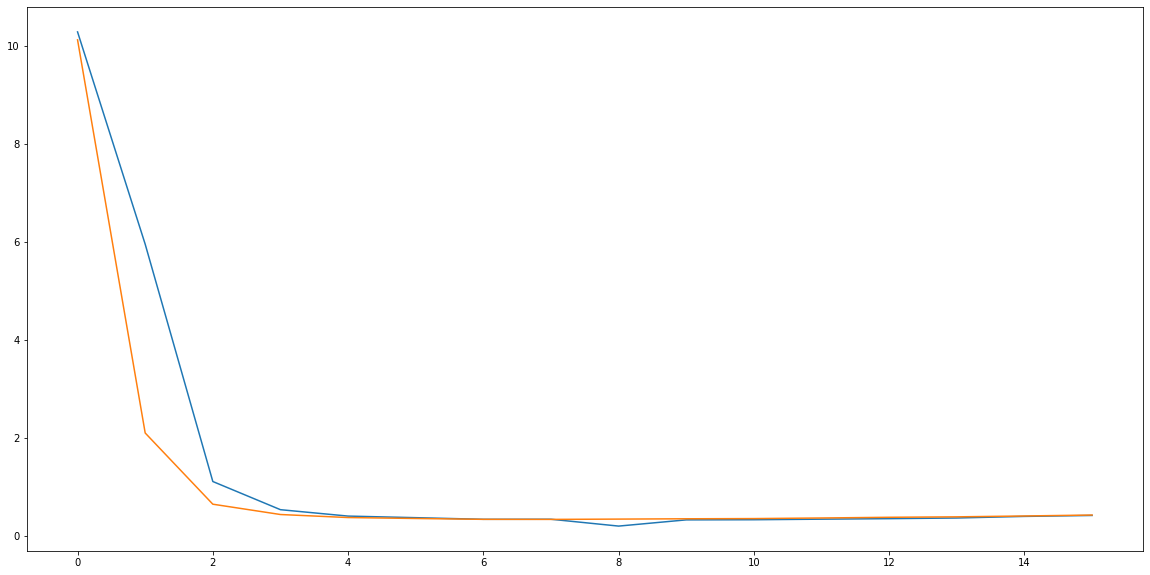

In [ ]:
model = CaptionNet(embed_size=2048, hidden_size=40, vocab_size=len(words_dicts)).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = 0) 


loses, val_losses = train(decoder=model, trainloader=train_loader, validloader=valid_loader, optimizer=optimizer, criterion=criterion, vocab_size=len(words_dicts), n_ep = 2)

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(loses)
plt.plot(val_losses)
plt.show()

Epoch: 1, Train loss: 10.246899604797363, Valid loss: 9.882507857760867
Epoch: 1, Train loss: 2.6325564378016706, Valid loss: 1.203509230549271
Epoch: 1, Train loss: 0.8996900687346587, Valid loss: 0.6838206086609815
Epoch: 1, Train loss: 0.585064223005965, Valid loss: 0.5011112727828928
Epoch: 1, Train loss: 0.47237239109503254, Valid loss: 0.4175506074283574
Epoch: 1, Train loss: 0.3887059163402867, Valid loss: 0.3859057591573612
Epoch: 1, Train loss: 0.36037714827705075, Valid loss: 0.345549196246508
Epoch: 1, Train loss: 0.33818495172906565, Valid loss: 0.32188446715071395
Epoch: 2, Train loss: 0.4895024299621582, Valid loss: 0.30613802629145415
Epoch: 2, Train loss: 0.27827648230501123, Valid loss: 0.2786651098446266
Epoch: 2, Train loss: 0.2690559075088114, Valid loss: 0.2608201870644415
Epoch: 2, Train loss: 0.23548457904441936, Valid loss: 0.24406879663064673
Epoch: 2, Train loss: 0.22685327747383632, Valid loss: 0.22787675190012197
Epoch: 2, Train loss: 0.22505617671318956, Va

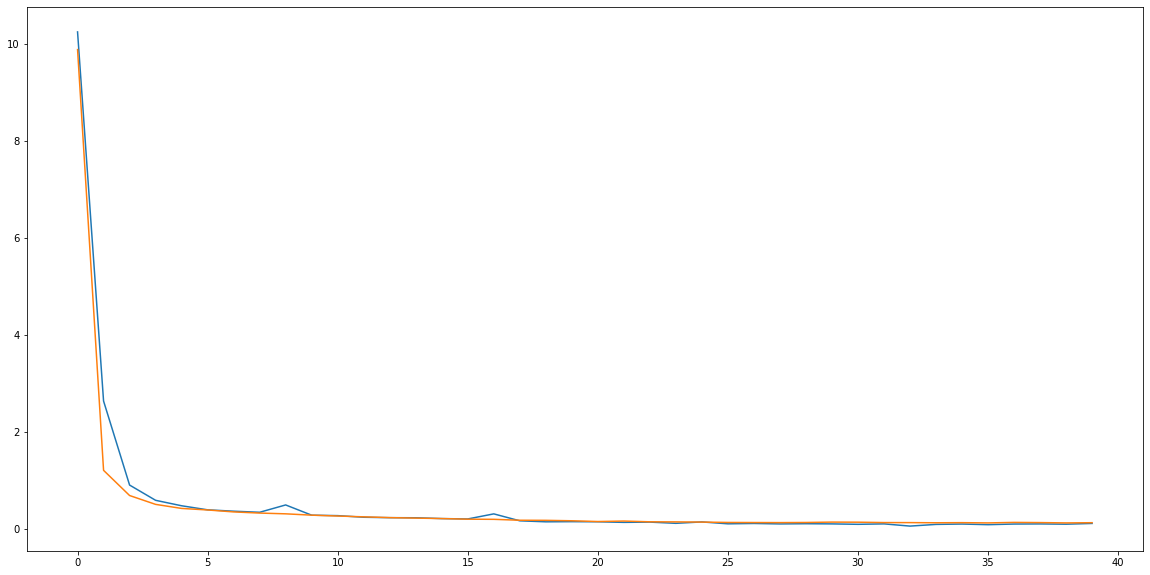

In [ ]:
model2 = CaptionNet(embed_size=2048, hidden_size=4000, vocab_size=len(words_dicts)).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = 0) 


loses2, val_losses2 = train(decoder=model2, trainloader=train_loader, validloader=valid_loader, optimizer=optimizer2, criterion=criterion, vocab_size=len(words_dicts), n_ep = 5)

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(loses2)
plt.plot(val_losses2)
plt.show()

In [ ]:
caption_from_vec(torch.tensor(img_codes[0]).unsqueeze(0),model2)

torch.Size([1, 14]) tensor([[   1, 4545, 4545, 4545, 4545, 4545, 4545, 4545, 4545, 4545, 4545, 4545,
         4545, 4545]], device='cuda:0')


['sos',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried',
 'dried']

In [ ]:
model_D = DecoderRNN(embed_size=2048, hidden_size=4096, vocab_size=len(words_dicts), num_layers=1).to(device)
optimizer_D = optim.Adam(model_D.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = 0) 

loses_D, val_losses_D = train(decoder=model_D, trainloader=train_loader, validloader=valid_loader, optimizer=optimizer_D, criterion=criterion, 
                                  vocab_size=len(words_dicts), n_ep = 3)

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(loses_D)
plt.plot(val_losses_D)
plt.show()

Epoch: 1, Train loss: 10.250614166259766, Valid loss: 9.865825318001413
Epoch: 1, Train loss: 6.165396035684122, Valid loss: 4.639187092394442
Epoch: 1, Train loss: 4.276253093255533, Valid loss: 4.000839208267831
Epoch: 1, Train loss: 3.8829737585944097, Valid loss: 3.818400950045199
Epoch: 1, Train loss: 3.7301498993023023, Valid loss: 3.683944249153137
Epoch: 1, Train loss: 3.6588410609477275, Valid loss: 3.663934404141194
Epoch: 1, Train loss: 3.6175326463338493, Valid loss: 3.581751630757306
Epoch: 1, Train loss: 3.591577536350972, Valid loss: 3.587161660194397
Epoch: 2, Train loss: 3.5680224895477295, Valid loss: 3.575258539174054
Epoch: 2, Train loss: 3.512202141736005, Valid loss: 3.4924398628441065
Epoch: 2, Train loss: 3.4429271543348157, Valid loss: 3.5076038186614578
Epoch: 2, Train loss: 3.4569929638424437, Valid loss: 3.489678011713801
Epoch: 2, Train loss: 3.4506877074370514, Valid loss: 3.4477456866083918
Epoch: 2, Train loss: 3.4091746510686103, Valid loss: 3.418217768

#### 50% Teacher forcing

In [ ]:
# натреним модель без тичер форсинга и глянем результаты
model_50tf = CaptionNet(embed_size=2048, hidden_size=4096, vocab_size=len(words_dicts)).to(device)
optimizer_50tf = optim.Adam(model_50tf.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = 0) 


loses_50tf, val_losses_50tf = train(decoder=model_50tf, trainloader=train_loader, validloader=valid_loader, optimizer=optimizer_50tf, criterion=criterion, 
                                  vocab_size=len(words_dicts), n_ep = 3, teacher_forcing=0.5)

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(loses_50tf)
plt.plot(val_losses_50tf)
plt.show()

In [ ]:
# натреним модель без тичер форсинга и глянем результаты
model_ntf = CaptionNet(embed_size=2048, hidden_size=4096, vocab_size=len(words_dicts)).to(device)
optimizer_ntf = optim.Adam(model_ntf.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = 0) 


loses_ntf, val_losses_ntf = train(decoder=model_ntf, trainloader=train_loader, validloader=valid_loader, optimizer=optimizer_ntf, criterion=criterion, 
                                  vocab_size=len(words_dicts), n_ep = 3, teacher_forcing=0)

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(loses_ntf)
plt.plot(val_losses_ntf)
plt.show()

## Inseption и получение результатов


In [27]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
iception_path = 'gdrive/MyDrive/Colab_Notebooks/dls_2/21_DIPLOM_Image_captioning/beheaded_inception3.py'
!cp $iception_path beheaded_inception3.py

from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


--2021-07-16 08:49:38--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-07-16 08:49:38--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.004s  

2021-07-16 08:49:38 (14.4 MB/s) - ‘img.jpg’ saved [54731

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 2048])
vectors_neck.shape: torch.Size([1, 2048])
features.shape: torch.Size([1, 1, 2048])
['sos', 'a', 'man', 'is', 'sitting', 'on', 'a', 'table', '', 'eos']


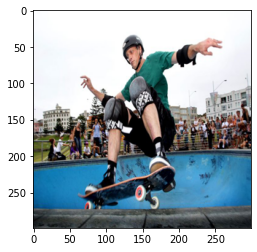

In [28]:
from PIL import Image
# from scipy.misc.pilutil import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = Image.open('img.jpg')
img = img.resize((299, 299))
plt.imshow(img)

print(generate_caption(img, model_test2, model_type='1'))

### Сгенерируем описание

Скачаем пару картинок, чтобы проверить качество:

In [29]:
def generate_caption(image, model, model_type = '1'):
    # приведение типов и нормализация
    image = np.array(image)/255

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    sfm = nn.Softmax(dim=1)
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    vectors_8x8, vectors_neck, logits = inception(image[None])
    print(vectors_neck.shape)
    if model_type !=  '1':
      vectors_neck = vectors_neck.squeeze()
    print(f'vectors_neck.shape: {vectors_neck.shape}')
    words = caption_from_vec_2(vectors_neck, model)
    return words

# print(generate_caption(img, model))
# print(generate_caption(img, model_ntf))
# print(generate_caption(img, model_50tf))
print(generate_caption(img, model_test2, model_type='1'))


torch.Size([1, 2048])
vectors_neck.shape: torch.Size([1, 2048])
features.shape: torch.Size([1, 1, 2048])
['sos', 'a', 'man', 'is', 'sitting', 'on', 'a', 'table', '', 'eos']


In [ ]:
from PIL import Image
# from scipy.misc.pilutil import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = Image.open('img.jpg')
img = img.resize((299, 299))
plt.imshow(img)

--2021-07-16 08:50:40--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-16 08:50:40--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   410KB/s    in 0.3s    

2021-07-16 08:50:40 (410 KB/s) - ‘img.jpg’ saved [106870/106870]



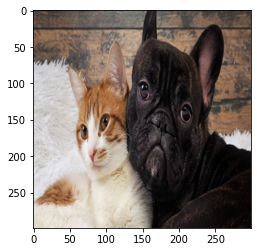

torch.Size([1, 2048])
vectors_neck.shape: torch.Size([1, 2048])
features.shape: torch.Size([1, 1, 2048])
['sos', 'a', 'man', 'is', 'sitting', 'on', 'a', 'table', '', 'eos']


In [30]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = Image.open('img.jpg')
img = img.resize((299, 299))

plt.imshow(img)
plt.show()

print(generate_caption(img, model_test2, model_type='1'))

# for i in range(10):
#     print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [31]:
print(generate_caption(img, model_test, model_type='2'))

torch.Size([1, 2048])
vectors_neck.shape: torch.Size([2048])
features.shape: torch.Size([1, 2048])
['sos', 'eventually', 'eventually', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have', 'have']


# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

In [ ]:
# apply your network on images you've found
#
#

## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.

# Выводы

- Был взят проект по Image Captioning
- Была обучена LSTM ка, способная по вектору изображение воспроизвести прикладыывающийся к картинке текст
- График лоса показывает, что архитектура и всякиие предобработки были построены верно
- Вся основная часть, в т.ч. написанные с 0 манипуляции с данными, обернутые в датасет и даталоадер, работают ок, сеточка тоже сходится, надеюсь работа выполнена удовлетворительно
- К сожалению дедлайн совпал с попной болью на работе и не удалось привести проект в вид, который хотелось
- После отчаянных попыток завести инференс была написана, from scratch, новая моделька, с немного изменнненым lstm, и лишенная убого зависания на инференсе.. но на текущий момент я не могу ее обучить до ок качества :)
- Чтобы проводить дофига эксперимемнтов, был прикручен wandb, методы используемые до его тоже оставлены, чтобы на будущее у меня была тетрадка с примером, как его прикрутить в уже существующий проект с немалым кол-вом кода)
- Райт нау я запущу эксперименты со 2й моделькой и другими параметрами, параллельно в копии этой тетрадки попробую подебажить первую модель (на это уже убита, наверное, человеконеделя чистого времени) и/или написать гибрид
- Завтра оберну оптимальную, на тот момент (вполне вероятна, что она будет ужасна, лол) модельку в ТГ бота и выложу. Это будет не тот бот, которого мы хотели, но вероятно то, которого заслуживаем))

- Вообще, я взял этот проект с прикольной идеей генерить упоротые подписи, т.е. как в старых переводах русских фильмов и просто мемные фразы, типо "Мальчик катается на велосипеде" -> "Маленький злодей спер велик и делает ноги". Ну т.е. понятно, что есть и менее упоротые применения для таких сеток) Но сетка, описывающая фотки как истиный мемолог мне кажется это тот ЭйАй, который мы заслужили)
- И я реализую эту идею в виде бота ТГ. Какие то разработки под него уже написаны, mvp будет тут к выходным. Надеюсь, получу за него > 0 баллов (хотя и признаю, что любой код, выложенный после дедлайна оценивается на усмотрение учителя :)